# Movie Recommendation System Using Content Based Filtering

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_movie   = pd.read_csv(os.getcwd() + '\\dataset\\tmdb_5000_movies.csv')
df_credits = pd.read_csv(os.getcwd() + '\\dataset\\tmdb_5000_credits.csv')

df_credits.rename(columns={'movie_id': 'id'}, inplace=True)
df_movie = df_movie.merge(df_credits, on='id')
df_movie.drop('id', inplace=True, axis=1)

## Check for Missing Values
* We found 64% of missing homepages, 17.6% of missing taglines, and small portion of missing overview, runtime, and release date.
* Homepages and taglines are categorical, and the others weren't be the important features, hence we can ignore this.

In [3]:
# Check for missing Values
missing_values = pd.DataFrame({'missing_values': df_movie.isnull().sum()/len(df_movie)*100})
missing_values[missing_values['missing_values'] > 0].sort_values('missing_values', ascending = False)

,missing_values
homepage,64.355611
tagline,17.572351
overview,0.062461
runtime,0.041641
release_date,0.020820


## Data Mining Part 1 - Returns feature by parsing JSON list

In [4]:
casts = ['Editor', 'Producer', 'Writer', 'Director']
for cast in casts:
    df_movie[cast] = df_movie['crew'].apply(lambda x:list({x.get('name') for x in json.loads(x) if x.get('job') == cast}))

features = ['keywords', 'production_companies', 'production_countries', 'genres']
for feature in features:
    df_movie[feature] = df_movie[feature].apply(lambda x:[i.get('name') for i in json.loads(x)])

In [5]:
df_movie_numerical = df_movie.select_dtypes('number')
df_movie_categorical = df_movie.select_dtypes('object')[['original_title', 'keywords', 'genres', 'original_language', 'production_companies', 'cast', 'Director', 'Producer', 'Writer', 'Editor']]
df_movie = pd.concat([df_movie_numerical, df_movie_categorical], axis = 1)

## Data Mining Part 2 - Filter Top 3 Most Frequent Keywords, Genres, and Cast.

In [6]:
features_top3 = ['keywords', 'genres', 'cast']
for feature in features_top3:
    unique_ = [item for sublist in df_movie[feature].tolist() for item in sublist]
    unique_ = pd.DataFrame({feature: unique_}).groupby(feature).size()
    df_movie[feature] = df_movie[feature].apply(lambda x:unique_[(unique_.index).isin(pd.Series(x, dtype='object'))].sort_values(ascending = False)[:3].index.tolist())

## Data Mining Part 3 - Cleanup Selected Feature by Lowercase Them

In [7]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
# Apply clean_data function to your features.
features = ['keywords', 'genres', 'cast', 'Director']

for feature in features:
    df_movie[feature] = df_movie[feature].apply(clean_data)

## Data Mining Part 4 (Modelling) - Create Vector for Cosine Similarity Input
* This depends on how similar of keywords, genres, cast, and director.

In [8]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['Director']) + ' ' + ' '.join(x['genres'])
df_movie['soup'] = df_movie.apply(create_soup,axis=1)

In [9]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_movie['soup'])

# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Reset index of our main DataFrame and construct reverse mapping as before
df_movie = df_movie.reset_index()
indices = pd.Series(df_movie.index, index=df_movie['original_title'])

In [10]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_movie['original_title'].iloc[movie_indices]

In [11]:
get_recommendations('The Dark Knight Rises')

65           The Dark Knight
119            Batman Begins
611     The Sum of All Fears
1178           Vantage Point
1269       Raise the Titanic
2646          Silent Trigger
3020              Sugar Hill
3284          Brooklyn Rules
3299                 Swelter
3359             In Too Deep
Name: original_title, dtype: object

## Data Mining Part 5 - Visualization
* Diving into the data, we can check:
    * Frequency of the keywords were found in the dataset.
    * Proportion of original language.
    * Possible linear relationship between budget and revenue, split by counts of genres.
    * Imbalanced genres distribution.

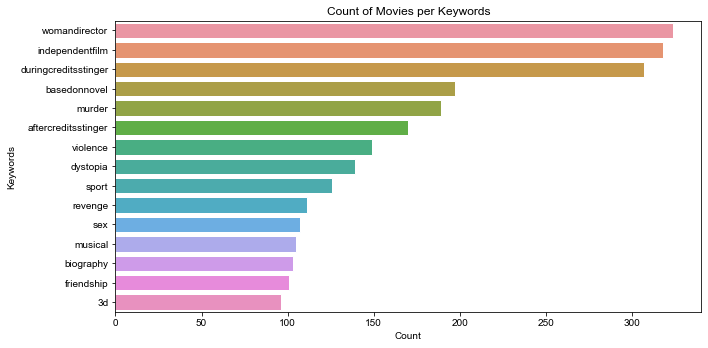

In [12]:
unique_keywords = [item for sublist in df_movie['keywords'].tolist() for item in sublist]
df = pd.DataFrame({'keywords': unique_keywords}).groupby('keywords').size().reset_index(name='count').sort_values('count', ascending = False).head(15)

figure, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.set_theme(style="darkgrid")
ax = sns.barplot(y = 'keywords', x = 'count', data = df)
ax.set_title('Count of Movies per Keywords')
ax.set_xlabel('Count')
ax.set_ylabel('Keywords')
plt.tight_layout()

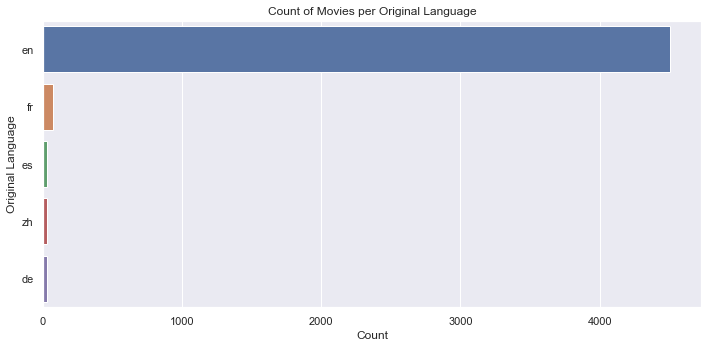

In [13]:
df = df_movie.groupby(['original_language']).size().reset_index(name='count').sort_values('count', ascending = False).head(5)

figure, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.set_theme(style="darkgrid")
ax = sns.barplot(y = 'original_language', x = 'count', data = df)
ax.set_title('Count of Movies per Original Language')
ax.set_xlabel('Count')
ax.set_ylabel('Original Language')
plt.tight_layout()

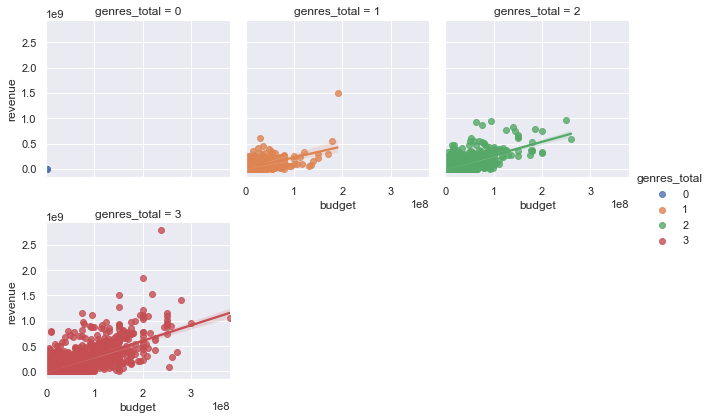

In [14]:
df_movie['genres_total'] = df_movie['genres'].apply(len)

g = sns.FacetGrid(df_movie, col_wrap=3, col="genres_total", hue="genres_total")
g.map(sns.regplot, "budget", "revenue")
g.add_legend()

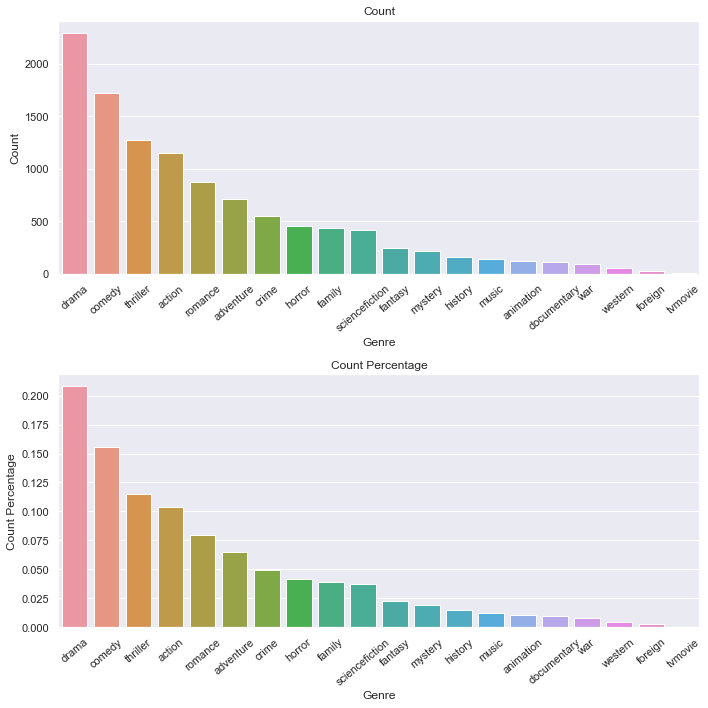

In [15]:
df_exploded = df_movie.explode('genres').groupby(['genres']).size().reset_index(name='count').sort_values('count', ascending = False).reset_index()
df_exploded['count_percentage'] = df_exploded['count'] / sum(df_exploded['count'])

labels = [['count', 'count_percentage'], ['Count', 'Count Percentage']]
fig, ax = plt.subplots(nrows = len(labels[0]), figsize = (10, 10))
sns.set_theme(style = 'dark')

for i in range(0, len(labels[0]), 1):
    sns.barplot(x = 'genres', y = labels[0][i], data = df_exploded, ax = ax[i])
    ax[i].set_title(labels[1][i])
    ax[i].set_xlabel('Genre')
    ax[i].set_ylabel(labels[1][i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=40)
    plt.tight_layout()